
# Where are the best places to live in california?
Wouldn't it be nice to take publicly avialble Census data and analyze it to figure out which locations in California have the best combination of high median income, low median rental costs, and "good" neighborhoods?
In this analysis I extract and clean California Census tract data, I create a metric to calculate the "goodness" of most of the Census tracts, I make models to try to understand which variables are highly correlated with "good" areas, and I create a heat map showing the goodness of each tract. 

## Data analytics skills demonstrated here:
* Basic scraping
* API usage
* Cleaning data and imputing missing values
* Examining correlations between predictors
* Building ridge regression models
* Plotting geographic heat map of response variable using geopandas

## Working with the Census API
In this project demographic data from US Census tables is extracted using the [python Census library](https://pypi.org/project/census/) then processed using other python libraries (like pandas).
* An [API key](https://www.census.gov/data/developers/guidance/api-user-guide.html) is required to request data from the census tables. 
* These Census tables contain 10s of thousands of variables. For this analysis I examined variables from the 2019 American Community Survey 1-year data (acs1). This survey contains a broad range of demographic data. A description of all the variables for the 2019 acs1 can be found [here](https://api.census.gov/data/2019/acs/acs1/variables.html). 


## You won't use all of the functions below
Many of these initial cells contain functions which were used to generate the 23.8 Mb data file that accompanies this notebook. 
Don't be alarmed if you see cells with functions that are never executed.

## Ok, let's get started!
The first task is to use our API key to connect to the census tables so that we can request data.

In [2]:

import pandas as pd
import numpy as np
from IPython.display import display

from census import Census # install python package to extrat data from census API tables
from us import states # us package simplifies FIPS codes for many geographies
import requests
from bs4 import BeautifulSoup 
import re

from collections import defaultdict
from datetime import datetime

# First locate the API key. Census API keys are available here:   https://www.census.gov/data/developers/guidance/api-user-guide.html

def connect_to_census(API_key_location):
    with open(API_key_location) as f:
        API_key_string = f.readlines()[0] # get the API key
    try:
        c = Census(API_key_string) # Make a connection to the census API
        print('Census API connections successful!')
    except:
        print('Error connecting to Census API')
        c = ''
    return c

# API_key_location = r'C:\census_key_location\census_API_key.txt' # Replace this with the path to your Census API key
# c = connect_to_census(API_key_location)

Now we have an API connection. But before we can make data requests we need to generate a list of variables of interest.
I've used the BeautifulSoup package along with a simple regex command to extract estimates for population totals (not grouped by age, sex or race) 
from the [2019 acs1 variable description page](https://api.census.gov/data/2019/acs/acs1/variables.html).


In [5]:

def get_variables(year):
    year = '2019'
    acs1_url = r"https://api.census.gov/data/" + year + r"/acs/acs1/variables.html" # URL for the specified year.
    # print(acs1_url)

    page = requests.get(acs1_url)
    soup = BeautifulSoup(page.content, 'html.parser') # parse html 
    # Find all variable names from the acs1 tables by fitting the regex pattern below:
    # Only select from detailed tables (base tables B) estimates (E) for totals from all ages, sexes, and races (_001E)
    # Do not factor in race at this time to keep the number of variables at a more managable level.
    acs1_var_str = r'\"variables\/(B[0-9]{5}_001E)\.json\"'
    acs1_var_patt = re.compile(acs1_var_str)

    content = soup.prettify() # create a clean string out of all the html

    # now use re.findall
    acs1_vars = re.findall(acs1_var_patt, content) # find the variable names that fit the pattern
    print("Number of acs1 variables: \n {}".format(len(acs1_vars)))

    return acs1_vars

acs1_vars = get_variables('2019')

Number of acs1 variables: 
 651


Scraping this page leaves us with 651 varialbes. This is a reasonable number to work with considering the 2019 acs tables contain over 26000 variables.
Unfortunately, some of these selected variables are actually incompatible with the python Census package, and if we try to use it to request data for these variables we will get an error.
Fortunately I found a table which groups all the 2019 acs variables by presence in acs1 or acs5 (5-year data), and I decided to only use variables that are present in both acs1 and acs5. This scheme allowed me to avoid errors while making data requests and reduced my variable count down to 620.

I created a file containing variable name prefixes for "allowed" variables. The following cell uses this file to reduce from 651 variables to 620 "allowed" variables:

In [6]:
# now we need to see which variable prefixes can be use for requests and narrow our list down based on this.
def get_allowed_vars(ap_location):
    allowed_prefixes = list(pd.read_csv(ap_location)['variable_prefix'])
    # print(len(allowed_prefixes))

    allowed_vars = []
    for var in acs1_vars:
        prefix, suffix = var.split('_')
        if prefix in allowed_prefixes:
            allowed_vars.append(var)

    print('total number of allowed variables: {}'.format(len(allowed_vars)))

    return allowed_vars

# select location of file containing allowed prefixes
ap_location = r'acs_allowed_prefixes.csv' 

allowed_vars = get_allowed_vars(ap_location)

total number of allowed variables: 620


## Defining a "Good neighborhoods" metric
In addition to these 620 "allowed variables" I will manually add 3 variables related to:
* Poverty rate
* Labor force participation
* Fraciton of single mother households

These additional variables will be used to create a "good neighborhoods" metric based off of the "good neighborhoods" metric from [housinginsights.org](http://housinginsights.org/data/census.html#:~:text=The%20U.S.%20Census%20American%20Community%20Survey%20provides%20useful,inventory%20in%20that%20area%20compares%20to%20the%20demand.)


In [7]:
allowed_vars += ['B17020_002E', 'B23025_002E', 'B09002_015E'] # Adding additional variables for "good neighborhoods" metric.


Now that we have 623 'allowed' variables that are compatible with the python census package. I will make API requests to get Census data for all Census tracts in all counties in California. The census API limits requests to 50 variables at a time, and sometimes requests fail. So I've made functions that make multiple requests (and retry if a request fails). After each request is complete the data is merged with a pandas DataFrame.

In [8]:

def multi_request(allowed_vars, max_attempts = 3): # try doing a request and if it fails try again until max_attempts is reached.
    request_status = False
    attempt_num = 1
    while (attempt_num <= max_attempts) and (request_status == False):
        try:
            print('Attempting request {} of {}'.format(attempt_num, max_attempts))
            req = c.acs.state_county_tract(tuple(allowed_vars), states.CA.fips, '*', '*') # just a test to see if I can run without errors.
            print('Request successful!')
            request_status = True
            return req
        except:
            print('Warning: Request failed!')
        attempt_num += 1


def request_all_vars_all_vals(allowed_vars):
    sect = 23 # break list of all vars into sections of length sect and request one sect of vars at a time.
    itterations = int(len(allowed_vars)/sect) # Number of requests excluding remainder.
    remainder = len(allowed_vars)%sect # final request, used if needed.
    print('Getting initial dataframe of first {} allowed variables...'.format(sect))
    request0 = multi_request(allowed_vars[0:sect]) # default of 3 request attempts
    print('Initial request successful. Creating dataframe and returning shape..')
    row_df = pd.DataFrame.from_dict(request0) # create DataFrame and populate with data for first set of requested variables.
    row_df = row_df.convert_dtypes() # convert to more easily usable data types.
    row_df = row_df.fillna(value=np.nan) # replace None values with pd.NA
    
    for itt in range(1,itterations): # Now make more requests and merge data with existing df.
        vstart = itt*sect
        vend = (itt+1)*sect
        request = multi_request(allowed_vars[vstart:vend])
        print('creating requested_df ...')
        requested_df = pd.DataFrame.from_dict(request)
        requested_df = requested_df.convert_dtypes() # convert to more easily usable data types.
        requested_df = requested_df.fillna(value=np.nan)# replace None values with pd.NA
        print('Shape of requested_df: {}'.format(requested_df.shape))
        print('merging with existing dataframe...')
        row_df = row_df.merge(requested_df, on = ["state","county","tract"], how = 'left')
        print('merge successful, dataframe has the following shape: {}'.format(row_df.shape))
        
    # now add on the last of the variables if there is a remainder.
    if remainder > 0:
        print('requesting remainder of variables:')
        print('resuming at variable index: {}'.format(vend))
        req_remainder = multi_request(allowed_vars[vend:])
        print('request for remainder of variables complete!')
        remainder_df = pd.DataFrame.from_dict(req_remainder)
        remainder_df = remainder_df.convert_dtypes() # convert to more easily usable data types.
        remainder_df = remainder_df.fillna(value=np.nan)# replace None values with pd.NA
        row_df = row_df.merge(remainder_df, on = ["state","county","tract"], how = 'left')
        print('shape of final dataframe: {}'.format(row_df.shape))
        
    return row_df

# acs1_full_df = request_all_vars_all_vals(allowed_vars)

Now that we've generated our DataFrame of interest we can export it to a csv file to use later.

In [12]:
def full_df_to_csv(acs1_full_df):
    curr_date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    data_path = r'acs1_full_data_set' + curr_date_time + '.csv'
    acs1_full_df.to_csv(data_path, index=False) # see what this makes and see how big the file size is.

# full_df_to_csv(acs1_full_df)


In [13]:
# Checking shape of full data frame
# print(acs1_full_df.shape)

## Data set for all CA Census tracts
This full DataFrame contains 9129 rows and 626 columns (626 variables for 9129 Census tracts).
When I convert it into a csv file, the file is about 23.8 Mb.\
The full 23.8 Mb file is included in this Github repository and it will be used below for the rest of the analysis.

In [14]:
# The function below generates a random sample from the full data set that is less than 10 Mb. I'll be working with the full data set so I don't need this function now.

# def sample_df_to_csv(acs1_full_df): # now sample 3650 rows at random so we can generate a csv file smaller than 10 Mb
#     acs1_sample_df = acs1_full_df.sample(3650, random_state = 3)
#     curr_date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
#     data_path = r'C:\Users\Edmund\OMSA\OMSA_scripts\OMSA_courses\CSE6040\extra_credit_working_with_census_data\acs1_sample' + curr_date_time + '.csv'
#     acs1_sample_df.to_csv(data_path, index=False) # see what this makes and see how big the file size is.

# sample_df_to_csv(acs1_full_df)

Now let's import the data from the CSV file and see what we are working with:

In [15]:

# Although I've made a smaller subset of the data I'd actually like to try using the full set if I can:
csv_path = r'acs1_full_data_set20221215-092520.csv'
acs_sample_df = pd.read_csv(csv_path)
print('ACS 2019 data shape for all census tracts: {} '.format(acs_sample_df.shape))

# There appears to be an issue here: The number of tracts doesn't match the 2019 geodata set. But the 2020 geodata set is a match, so we will use it and move on.


ACS 2019 data shape for all census tracts: (9129, 626) 


## Data cleaning
First I would like to detect DataFrame columns that are completely filled with NaN values and remove them from the data set

In [16]:
print("Let's looks at a column with blank entries:")
display(acs_sample_df['B08133_001E'])
# It would be nice to remove any columns that are entirely NaN entries.
acs_df = acs_sample_df.copy()# First make a copy of acs_sample_df to play with.
for col in acs_sample_df.columns:
    if acs_sample_df[col].isna().all(): # If all entries for the column are NaN then remove the column.
        del acs_df[col]
# After deleting empty columns what is the size of the data frame?
print('df shape after deleting empty columns: {}'.format(acs_df.shape))


Let's looks at a column with blank entries:


0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
9124        NaN
9125        NaN
9126        NaN
9127    62815.0
9128        NaN
Name: B08133_001E, Length: 9129, dtype: float64

df shape after deleting empty columns: (9129, 524)



Wow, there were a lot of empty columns! removing these columns significantly decreases the variable count from 627 to 524!



## Living with highly correlated variables
I suspect that many of the variables in this DataFrame correlate exactly with each other (correlation = 1). Variables that exactly correlate may be redundant (for example: "PEOPLE REPORTING ANCESTRY" and "ANCESTRY"), or they may be subsets of eachother (for example: "PEOPLE REPORTING ANCESTRY" and "HISPANIC OR LATINO ORIGIN"). 

The function below attempts to group all variables with correlation = 1 into sets. I can then pick out a single variable from each set and discard the others. Discarding redundant variables may make it easier to generate good models without sacrificing releavant information.

In [17]:
# Now let's make a correlation matrix between all the variables. Variables that are perfectly correlated may be redundant, and could be removed. 

# can I make a correlation matrix despite NaN values?
acs_corr_mat1 = acs_df.corr()
# print(type(acs_corr_mat1))
print('Shape of correlation matrix: \n {}'.format(acs_corr_mat1.shape))
# print(acs_corr_mat1)

var_list_unchanged = False # Set this to true in the while loop if no new sets of variables are found then break out of the loop.
correlated_vars_lists = []
while not var_list_unchanged:
    var_list = [acs_corr_mat1.iloc[:,0].name] # first var in var_list is the zeroth column of the matrix.
    for idx, col_name in enumerate(acs_corr_mat1.index):
        if (col_name != acs_corr_mat1.iloc[:,0].name) and (acs_corr_mat1.iloc[idx,0] == 1): # if correlation = 1 and you are not on the diagonal:
            var_list.append(col_name) # add name of pefectly correlated variable to the list
    # print('length of var_list: {}'.format(len(var_list)))
    if var_list == [acs_corr_mat1.iloc[:,0].name]: # If no new high correlation variables are added to the list then exit the while loop.
        var_list_unchanged = True
    else: # remove rows and columns from the correlation matrix then go back into the while loop and evaluate the smaller correlation matrix.
        correlated_vars_lists.append(var_list) # append set to master list.
        del acs_corr_mat1[var_list[0]]# remove 0th column
        acs_corr_mat1.drop(var_list[1:], inplace = True)# remove rows with correlation score of 1

print('Printing length of each list of perfectly correlated variables: {}'.format([len(x) for x in correlated_vars_lists]))
print('Printing each list of perfectly correlated variables: {}'.format([x for x in correlated_vars_lists]))


Shape of correlation matrix: 
 (524, 524)
Printing length of each list of perfectly correlated variables: [21, 3, 2]
Printing each list of perfectly correlated variables: [['B01001_001E', 'B01003_001E', 'B02001_001E', 'B03001_001E', 'B03002_001E', 'B03003_001E', 'B04006_001E', 'B04007_001E', 'B05001_001E', 'B05002_001E', 'B05003_001E', 'B05012_001E', 'B06001_001E', 'B06003_001E', 'B09019_001E', 'B99011_001E', 'B99012_001E', 'B99021_001E', 'B99031_001E', 'B99051_001E', 'B99061_001E'], ['B01002_001E', 'B05004_001E', 'B06002_001E'], ['B01003_001E', 'B01001_001E']]


So are the sets of variables above essentially replicates of each other?\
Let's look at variables from each set and try to decide:

**Set 0 (21 variables):**
B01001_001E: "Estimate!!Total:	SEX BY AGE"\ 
B01003_001E: "Estimate!!Total:	TOTAL POPULATION"\
B02001_001E: "Estimate!!Total:	RACE"\
B03001_001E: "Estimate!!Total:	HISPANIC OR LATINO ORIGIN BY SPECIFIC ORIGIN"\
B03002_001E: "Estimate!!Total:	HISPANIC OR LATINO ORIGIN BY RACE"\
B03003_001E: "Estimate!!Total:	HISPANIC OR LATINO ORIGIN"\
B04006_001E: "Estimate!!Total:	PEOPLE REPORTING ANCESTRY"\
B04007_001E: "Estimate!!Total:	ANCESTRY"\
B05001_001E: "Estimate!!Total:	NATIVITY AND CITIZENSHIP STATUS IN THE UNITED STATES"\
B05002_001E: "Estimate!!Total:	PLACE OF BIRTH BY NATIVITY AND CITIZENSHIP STATUS"\
B05003_001E: "Estimate!!Total:	SEX BY AGE BY NATIVITY AND CITIZENSHIP STATUS"\
B05012_001E: "Estimate!!Total:	NATIVITY IN THE UNITED STATES"\
B06001_001E: "Estimate!!Total:	PLACE OF BIRTH BY AGE IN THE UNITED STATES"\
B06003_001E: "Estimate!!Total:	PLACE OF BIRTH BY SEX IN THE UNITED STATES"\
B09019_001E: "Estimate!!Total:	HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP"\
B99011_001E: "Estimate!!Total:	ALLOCATION OF SEX"\
B99012_001E: "Estimate!!Total:	ALLOCATION OF AGE"\
B99021_001E: "Estimate!!Total:	ALLOCATION OF RACE"\
B99031_001E: "Estimate!!Total:	ALLOCATION OF HISPANIC OR LATINO ORIGIN"\
B99051_001E: "Estimate!!Total:	ALLOCATION OF CITIZENSHIP STATUS"\
B99061_001E: "Estimate!!Total:	ALLOCATION OF PLACE OF BIRTH"

Many of the perfectly correlated variables above refer to totals and seem to be redundant. Interestingly there are still variables here related to race despite my attempt to exclude them from the analysis. From set 0 I will only include B01003_001E (TOTAL POPULATION) and B03003_001E (HISPANIC OR LATINO ORIGIN) and remove the other variables from set 0.

**Set 1 (3 variables):**
B01002_001E: "Estimate!!Median age --!!Total:	MEDIAN AGE BY SEX"\
B05004_001E: "Estimate!!Total:	MEDIAN AGE BY NATIVITY AND CITIZENSHIP STATUS BY SEX"\
B06002_001E: "Estimate!!Median age --!!Total:	MEDIAN AGE BY PLACE OF BIRTH IN THE UNITED STATES"

Using multiple variables related to median age would be redundant, So I will keep B01002_001E (MEDIAN AGE BY SEX) and discard the others.

**Set 2**
Set 2 contains both variables from set 0, so I will ignore set 2.


Now lets remove these "redundant" variables.

In [18]:
# removing some perfectly correlated variables that seem to be redundant
redundant_vars_set0 = set(correlated_vars_lists[0]) - set(['B01003_001E', 'B03003_001E'])
print(redundant_vars_set0) 
redundant_vars_set1 = set(correlated_vars_lists[1]) - set(['B01002_001E'])
print(redundant_vars_set1)
redundant_vars_set0.update(redundant_vars_set1) # update set0 to include set1

# remove redundant columns from acs_df:
acs_df.drop(list(redundant_vars_set0), axis=1, inplace = True)
# now check the size of the dataframe
print('acs_df shape after removing redundant variables: {}'.format(acs_df.shape))


{'B99012_001E', 'B05002_001E', 'B05003_001E', 'B99051_001E', 'B05001_001E', 'B99011_001E', 'B99061_001E', 'B01001_001E', 'B03002_001E', 'B99021_001E', 'B99031_001E', 'B09019_001E', 'B06001_001E', 'B06003_001E', 'B04007_001E', 'B05012_001E', 'B04006_001E', 'B02001_001E', 'B03001_001E'}
{'B06002_001E', 'B05004_001E'}
acs_df shape after removing redundant variables: (9129, 503)


So there are still about 503 variables left. I suspect that many of these 503 variables are highly correlated based on Census question type. We can get a sense of the number of correlated variables, and how they are grouped, by making a heat map of the correlation matrix for this dataframe:


 



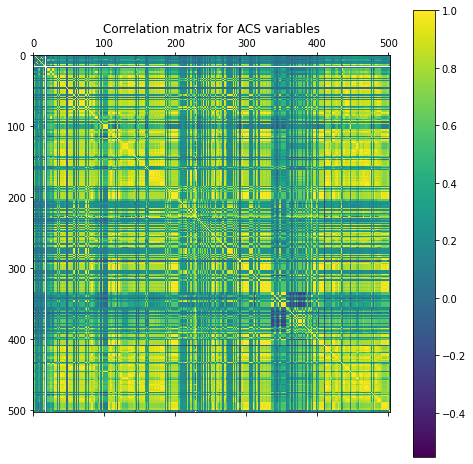

In [19]:
# now lets make a heat map of the correlation matrix and see how multicolinearity will effect our variables of interest:
import matplotlib.pyplot as plt
matfig = plt.figure(figsize=(8,8))
plt.matshow(acs_df.corr(), fignum=matfig.number)
plt.title('Correlation matrix for ACS variables')
plt.colorbar()
plt.show()

There appear to be many blocks of highly correlated variables. This should make building predictive models easy, but it may obscure some of the core variables that are true drivers of Census tract "goodness".

## Ridge regression
Since this data set appears to suffer from severe multicollinearity, I'll try ridge regression to create models for variables of interest with respect to the other ~500 variables. To test the concept I'll start by building a ridge model for variable "B19013_001E" (Median household income in the past 12 months):

In [20]:
# First make sure this variable is still included in my dataframe:
print('Is B19013_001E in acs_df?:  {}'.format(('B19013_001E' in list(acs_df.columns))))
print('Any negative values in acs_df?: {}'.format(( (acs_df < 0).values.any())))

Is B19013_001E in acs_df?:  True
Any negative values in acs_df?: True


## Imputing missing data
Before I can do ridge regression I need to impute data for all missing values in acs_df. I've decided to use sklearn's iterativeImpute function because it has the option to calculated imputed values based on the "n_nearest" most highly correlated features, and with this ACS data there are plenty of highly correlated features to go around:

In [21]:
from sklearn.experimental import enable_iterative_imputer # packages needed for iterative imputation.
from sklearn.impute import IterativeImputer

print("Let's look at some values in one of the columns before imputing values: {}".format(acs_df['B08133_001E'][0:5]))
print('Generating imputed values for NaN entries in acs_df. This may take a few seconds...')
# convert pd.NA to np.nan so we can use sklearn's iterativeImpute function.
acs_df = acs_df.replace({pd.NA: np.nan})
acs_df[acs_df < 0] = np.nan # There are multiple occurances of the number -6.7e8 I think these are nan placeholders. So I will converta all of these to np.nan values.
# Create the fit function 
# n_nearest_features looks for highly correlated features to help in imputation. Should be good for large multicollinearity.
imp_func = IterativeImputer(n_nearest_features = 3, random_state = 3, min_value = 0.0, max_iter = 20) # All variables should be related to total population. So the min imputed value should be 0
imp_func.fit(acs_df)
imp_mat = imp_func.transform(acs_df) # matrix with imputed values.
acs_imp_df = pd.DataFrame(imp_mat, columns = acs_df.columns) # make new df with imputed values.

print('Shape of DataFrame with imputed values: {}'.format(acs_imp_df.shape))
print('Any np.nan values left?:  {}'.format(acs_imp_df.isnull().values.any()))
print('Any negative values in acs_df?: {}'.format(( (acs_df < 0).values.any())))
print("Now let's look at one of the columns after imputing values: {}".format(acs_imp_df['B08133_001E'][0:5]))

Let's look at some values in one of the columns before imputing values: 0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: B08133_001E, dtype: float64
Generating imputed values for NaN entries in acs_df. This may take a few seconds...


c:\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


Shape of DataFrame with imputed values: (9129, 503)
Any np.nan values left?:  False
Any negative values in acs_df?: False
Now let's look at one of the columns after imputing values: 0    56818.505192
1    37101.242296
2    64873.907867
3    90327.795464
4    35641.370178
Name: B08133_001E, dtype: float64


It looks like we've successfully imputed missing values for all of our columns. But before we start making models we need to split the data into training and test sets. We'll start by using 'B19013_001E' (Median household income) as our response variable, and all other variables (excluding 'state','county' and 'tract') as our predictors:

In [22]:
from sklearn.model_selection import train_test_split
# Predictors include all variables except 'B19013_001E','state','county','tract'
X_column_names = list(set(acs_imp_df.columns) - set(['B19013_001E','state','county','tract'])) 
X = acs_imp_df[X_column_names]
y = acs_imp_df['B19013_001E'] # response variable
# Randomly sample 80% of data in acs_df for training/validation and save the other 20% for testing later.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 200)

In [23]:
# ridge regression adapted from: https://www.statology.org/ridge-regression-in-python/

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV


def acs_ridge_regression(X_train, y_train): # I need to reduce the number of variables to run this in a reasonable amount of time.
    #define cross-validation method to evaluate model: sklearn.model_selection.RepeatedKFold
    cv = RepeatedKFold(n_splits=4, n_repeats=2, random_state=1)

    #define model:  sklearn.linear_model.RidgeCV
    model = RidgeCV(alphas=np.arange(0.1,1.1,0.1), cv=cv, normalize = True) # Do not alow an alpha = 0 penalty (ordinary least squares)

    #fit model
    model.fit(X_train, y_train)

    #display lambda that produced the lowest test MSE
    print('Ridge model lambda parameter for lowest MSE: {}'.format(model.alpha_))
    
    return model

ridge_model = acs_ridge_regression(X_train, y_train)
print('Number of coefficients calculated by ridge regression model: {}'.format(ridge_model.coef_.shape[0]))


Ridge model lambda parameter for lowest MSE: 0.1
Number of coefficients calculated by ridge regression model: 499


So we've done a basic ridge regression. Now let's sort the coefficients and see which ones are the largest:

In [24]:
ridge_coeff_df = pd.DataFrame({'X column names':X_column_names, 'Ridge coefficients': ridge_model.coef_})
# sort the df from largest to smallest coefficients
ridge_coeff_df.sort_values(by=['Ridge coefficients'], inplace=True, ascending=False)
display(ridge_coeff_df.head()) # display twenty largest coefficients
print("Let's also look at some of the negative coefficients with the largest magnitude:")
display(ridge_coeff_df.tail()) # display twenty largest coefficients


,X column names,Ridge coefficients
85,B25018_001E,621.689762
66,B25010_001E,506.228488
498,B25021_001E,264.562931
286,B23013_001E,13.504529
150,B25105_001E,1.900100


Let's also look at some of the negative coefficients with the largest magnitude:


,X column names,Ridge coefficients
100,B23020_001E,-42.118493
330,B25039_001E,-52.580723
338,B25071_001E,-62.295614
328,B19082_001E,-731.000365
191,B19083_001E,-19108.661855


For this ridge regression our variable of interest is 'B19013_001E' (Median household income)
The three variables with the largest positive coefficients are:
* 'B25018_001E' (MEDIAN NUMBER OF ROOMS)
* 'B25010_001E' (AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE) 
* 'B25021_001E' (MEDIAN NUMBER OF ROOMS BY TENURE)
There are also variables with large negative coefficients which may be good predictors for median income; for example:
* 'B19083_001E' (GINI INDEX OF INCOME INEQUALITY) 
* 'B19082_001E' (SHARES OF AGGREGATE HOUSEHOLD INCOME BY QUINTILE) 
* 'B25071_001E' (MEDIAN GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS (DOLLARS))

The strong relationships between the variables above to median household income are obvious, but this gives us evidence that this ridge model is realistic, and gives confidence that other ridge regression models for Census tract "goodness" are likely to give good results.

Now let's see how accurate this model's predictions are:

R^2 : 0.9942837030571257


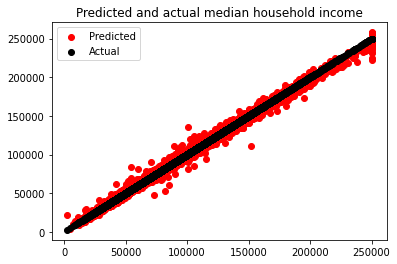

In [25]:
#Generate predictions for each census tract in the test data set:
y_pred_ridge = ridge_model.predict(X_test)
# Let's look at the coefficient of determination (R^2) for this ridge model:
ridge_score = ridge_model.score(X_test, y_test)
print("R^2 : {}".format(ridge_score))

# Let's also create a plot to examine predicted and actual median household income values
y_pred_all = ridge_model.predict(X) # predict median income for all X values using the ridge model.

plt.scatter(y, y_pred_all, color = 'red', label = 'Predicted')
plt.scatter(y , y, color = 'black', label = 'Actual')
plt.title('Predicted and actual median household income')
plt.legend()
plt.legend()

plt.show()

So the ridge model accounts for 99.4 % of the variance in the test data. That's a very good result. But we should expect good predictions given the huge number of highly correlated variables. Now that we know we can make decent models with ridge regression let's tackle a question that's a little more interesting:




# "Good Neighborhoods"
In this analysis I've purposely included variables about:
* Poverty rate: Fraction of population below the poverty rate
* Labor force participation: Share of people at least 16 years old that are in the labor force
* Fraciton of single mother households: Number of single mothers divided by total population

The 3 variables found above come from a metrc for "good neighborhoods" that I found [here](http://housinginsights.org/data/census.html#:~:text=The%20U.S.%20Census%20American%20Community%20Survey%20provides%20useful,inventory%20in%20that%20area%20compares%20to%20the%20demand.)

In addition I'll include a variable for median contract rent. The goal here is to look for "good" census tracts with reasonable rents.
Let's create a new variable called tract_goodness and define it as follows:
$$ Tract \ Goodness = \frac{(Median \ household \ income)*(Labor \ force \ participation)*( 1 - Poverty \ rate)*(1 - Fraction \ of \ single \ mother \ households)}{(Median \ contract \ rent)} $$

In the above expression, poverty rate and fraction of single mother households are both in the numerator to avoid division by 0.

If it seems like the variables that make up tract_goodness are arbitrary, it's because they are. I may use these variables to rank the best and worst places to live in California, but someone else might use a completely different critera.

Now I'll define the tract goodness variable then create a ridge regression model based on it:

Creating new ridge regression model for tract goodness...
Ridge model lambda parameter for lowest MSE: 0.1
R^2 for tract goodness model : 0.8006750048855715


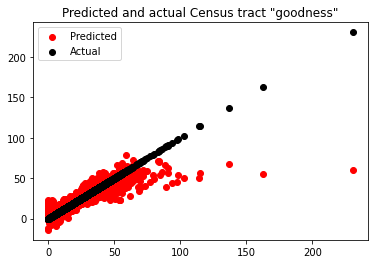

In [26]:

# Before dividing by population 'B01003_001E'. We need to remove all Census tracts with 0 population. this is safe to do, because for this analysis we are only interested in populated tracts.
acs_imp_df = acs_imp_df[acs_imp_df['B01003_001E'] != 0] # Rows of the dataframe where the population is nonzero.
# print('shape of acs_imp_df: {}'.format(acs_imp_df.shape))

# First let's define Labor force participation, poverty rate, and fraction of single mother households:
labor_force_prtc = acs_imp_df['B23025_002E'] / acs_imp_df['B01003_001E']
# print('max labor force participation: {}'.format(max(labor_force_prtc)))
poverty_rate = acs_imp_df['B17020_002E'] / acs_imp_df['B01003_001E']
# print('max poverty rate: {}'.format(max(poverty_rate)))
frac_single_mom = acs_imp_df['B09002_015E'] / acs_imp_df['B01003_001E']
# print('max frac single mom households: {}'.format(max(frac_single_mom)))
median_income = acs_imp_df['B19013_001E'] # median household income
median_rent = acs_imp_df['B25058_001E'] # median contract rent
# print('min rent: {}'.format(min(median_rent)))

# tract goodness = y_tg
y_tg = median_income * labor_force_prtc * (1 - poverty_rate) * (1 - frac_single_mom) / median_rent

# print('Does y_tg contain nan values? : {}'.format(y_tg.isnull().any()))
# print('Does labor_force_prtc contain nan values? : {}'.format(labor_force_prtc.isnull().any()))
# print('Does total population contain any zero values? : {}'.format(acs_imp_df[acs_imp_df['B01003_001E'] == 0]))
# print('Does poverty rate contain nan values? : {}'.format(poverty_rate.isnull().any()))

# display(y_tg.head())
# print(type(y_tg))
# print(y_tg.name)

# print(len(acs_imp_df['B17020_002E'][acs_imp_df['B17020_002E'] == 0])) # where is the poverty rate 0 ?
# print(min(acs_imp_df['B17020_002E'][acs_imp_df['B17020_002E'] > 0])) # print min non-zero poverty number value
# print(max(acs_imp_df['B17020_002E'][acs_imp_df['B17020_002E'] > 0])) # print max non-zero poverty number value
# print(acs_imp_df['B17020_002E'].median())
# print(len(acs_imp_df['B09002_015E'][acs_imp_df['B09002_015E'] == 0])) # where is the fraction of single mother households 0 ?
# print(min(acs_imp_df['B09002_015E'][acs_imp_df['B09002_015E'] > 0])) # print min non-zero single mother households value
# print(max(acs_imp_df['B09002_015E'][acs_imp_df['B09002_015E'] > 0])) # print max non-zero single mother households value
# print(acs_imp_df['B09002_015E'].median())
# print(len(acs_imp_df['B25058_001E'][acs_imp_df['B25058_001E'] == 0])) # where is median contract rent 0 ?


# Exclude all response variables from the set of predictors
X_tg_column_names = list(set(acs_imp_df.columns) - set(['B23025_002E', 'B01003_001E', 'B17020_002E', 'B09002_015E' , 'B19013_001E' 'B25058_001E' ,'state','county','tract'])) 
X_tg = acs_imp_df[X_tg_column_names]
# Randomly sample 80% of data in acs_df for training/validation and save the other 20% for testing later.
X_tg_train, X_tg_test, y_tg_train, y_tg_test = train_test_split(X_tg, y_tg, test_size = 0.2, random_state = 200)
print('Creating new ridge regression model for tract goodness...')
ridge_model_tg = acs_ridge_regression(X_tg_train, y_tg_train)
#Generate predictions for each census tract in the test data set:
y_pred_tg = ridge_model_tg.predict(X_tg_test)
# Let's look at the coefficient of determination (R^2) for this ridge model:
ridge_score_tg = ridge_model_tg.score(X_tg_test, y_tg_test)
print("R^2 for tract goodness model : {}".format(ridge_score_tg))

# let's also create a plot to show predicted versus actual tract goodness:
y_tg_pred_all = ridge_model_tg.predict(X_tg) # predict median income for all X values using the ridge model.

plt.scatter(y_tg, y_tg_pred_all, color = 'red', label = 'Predicted')
plt.scatter(y_tg , y_tg, color = 'black', label = 'Actual')
plt.title('Predicted and actual Census tract "goodness"')
plt.legend()
plt.show()


# Visualizing Census tract goodness
This ridge model makes good predictions when tract goodness is less than 100, but poor predictions for very high tract goodness. There could be a simple explanation, such as the model suffering from the effects of outliers, or there might be a non-linear relationship between the tract goodness and some of its most significant predictors. I may examine these ideas later, but first I would like
to use the geopandas library to create heat maps showing the predicted and actual tract goodness values for the full set of census tracts.

To construct the heatmap of California Census tracts I used a shape file (.shp) which contains geometric/geographic data to construct each Census tract and position it on the map. The U.S. Census bureau kindly supplies these files, and the year 2020 file that I'm using can be found [here](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Census+Tracts).
(It turns out the 2019 ACS data corresponds to the 2020 shape file).


In [27]:
# Adapted from geopandas example here: https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77
 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# shape_path references a shape file containing geographic data for CA Census tracts. The file can be downloaded here: 
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=Census+Tracts

# test to see what the shape of the 2020 shapefile is, because I expect more census tracts:
shape_path = r"C:\Users\Edmund\OMSA\OMSA_scripts\OMSA_courses\CSE6040\extra_credit_working_with_census_data\tl_2020_06_tract\tl_2020_06_tract.shp"
geo_df = gpd.read_file(shape_path)
geo_df = geo_df.to_crs("EPSG:4326")
geo_df[['COUNTYFP','TRACTCE']] = geo_df[['COUNTYFP','TRACTCE']].astype(int) # change county and tract to int to make subsequent merging easier.
print('geo_df.shape: {}'.format(geo_df.shape))

# test_geo = geo_df.iloc[0,:] # let's try printing some info
# Test plot of CA Census tracts:
# geo_df.boundary.plot()
# plt.show()

# What variables do I have to work with here?
# display(test_geo)
# print(type(test_geo))
# display(geo_df.head())

geo_df.shape: (9129, 13)


I now have a geopandas dataframe containing my geometric/geographic data for each census tract. The last step before I make a heatmap will be to merge the tract goodness values into the dataframe:

In [28]:
# Make a function to do merge any pandas series (response variable) with geo_df to prep it for mapping.
def merge_response_var(X, y, y_name):
    y_named = y.rename(y_name) # rename response data series
    y_county_tract=pd.concat([X['county'].astype(int),y_named],axis=1) # add in 'county' column (convert to int for merging)
    y_county_tract=pd.concat([X['tract'].astype(int),y_county_tract],axis=1) # add in 'tract' column (convert to int for merging)
    
    geo_y_df = geo_df.merge(y_county_tract, how='right', left_on = ['COUNTYFP','TRACTCE'], right_on = ['county','tract'])
    # display(geo_df_ytg.head())
    # print('shape of geo_df_ytg: {}'.format(geo_df_ytg.shape))
    return geo_y_df

geo_df_ytg = merge_response_var(acs_imp_df, y_tg, 'y_tg')

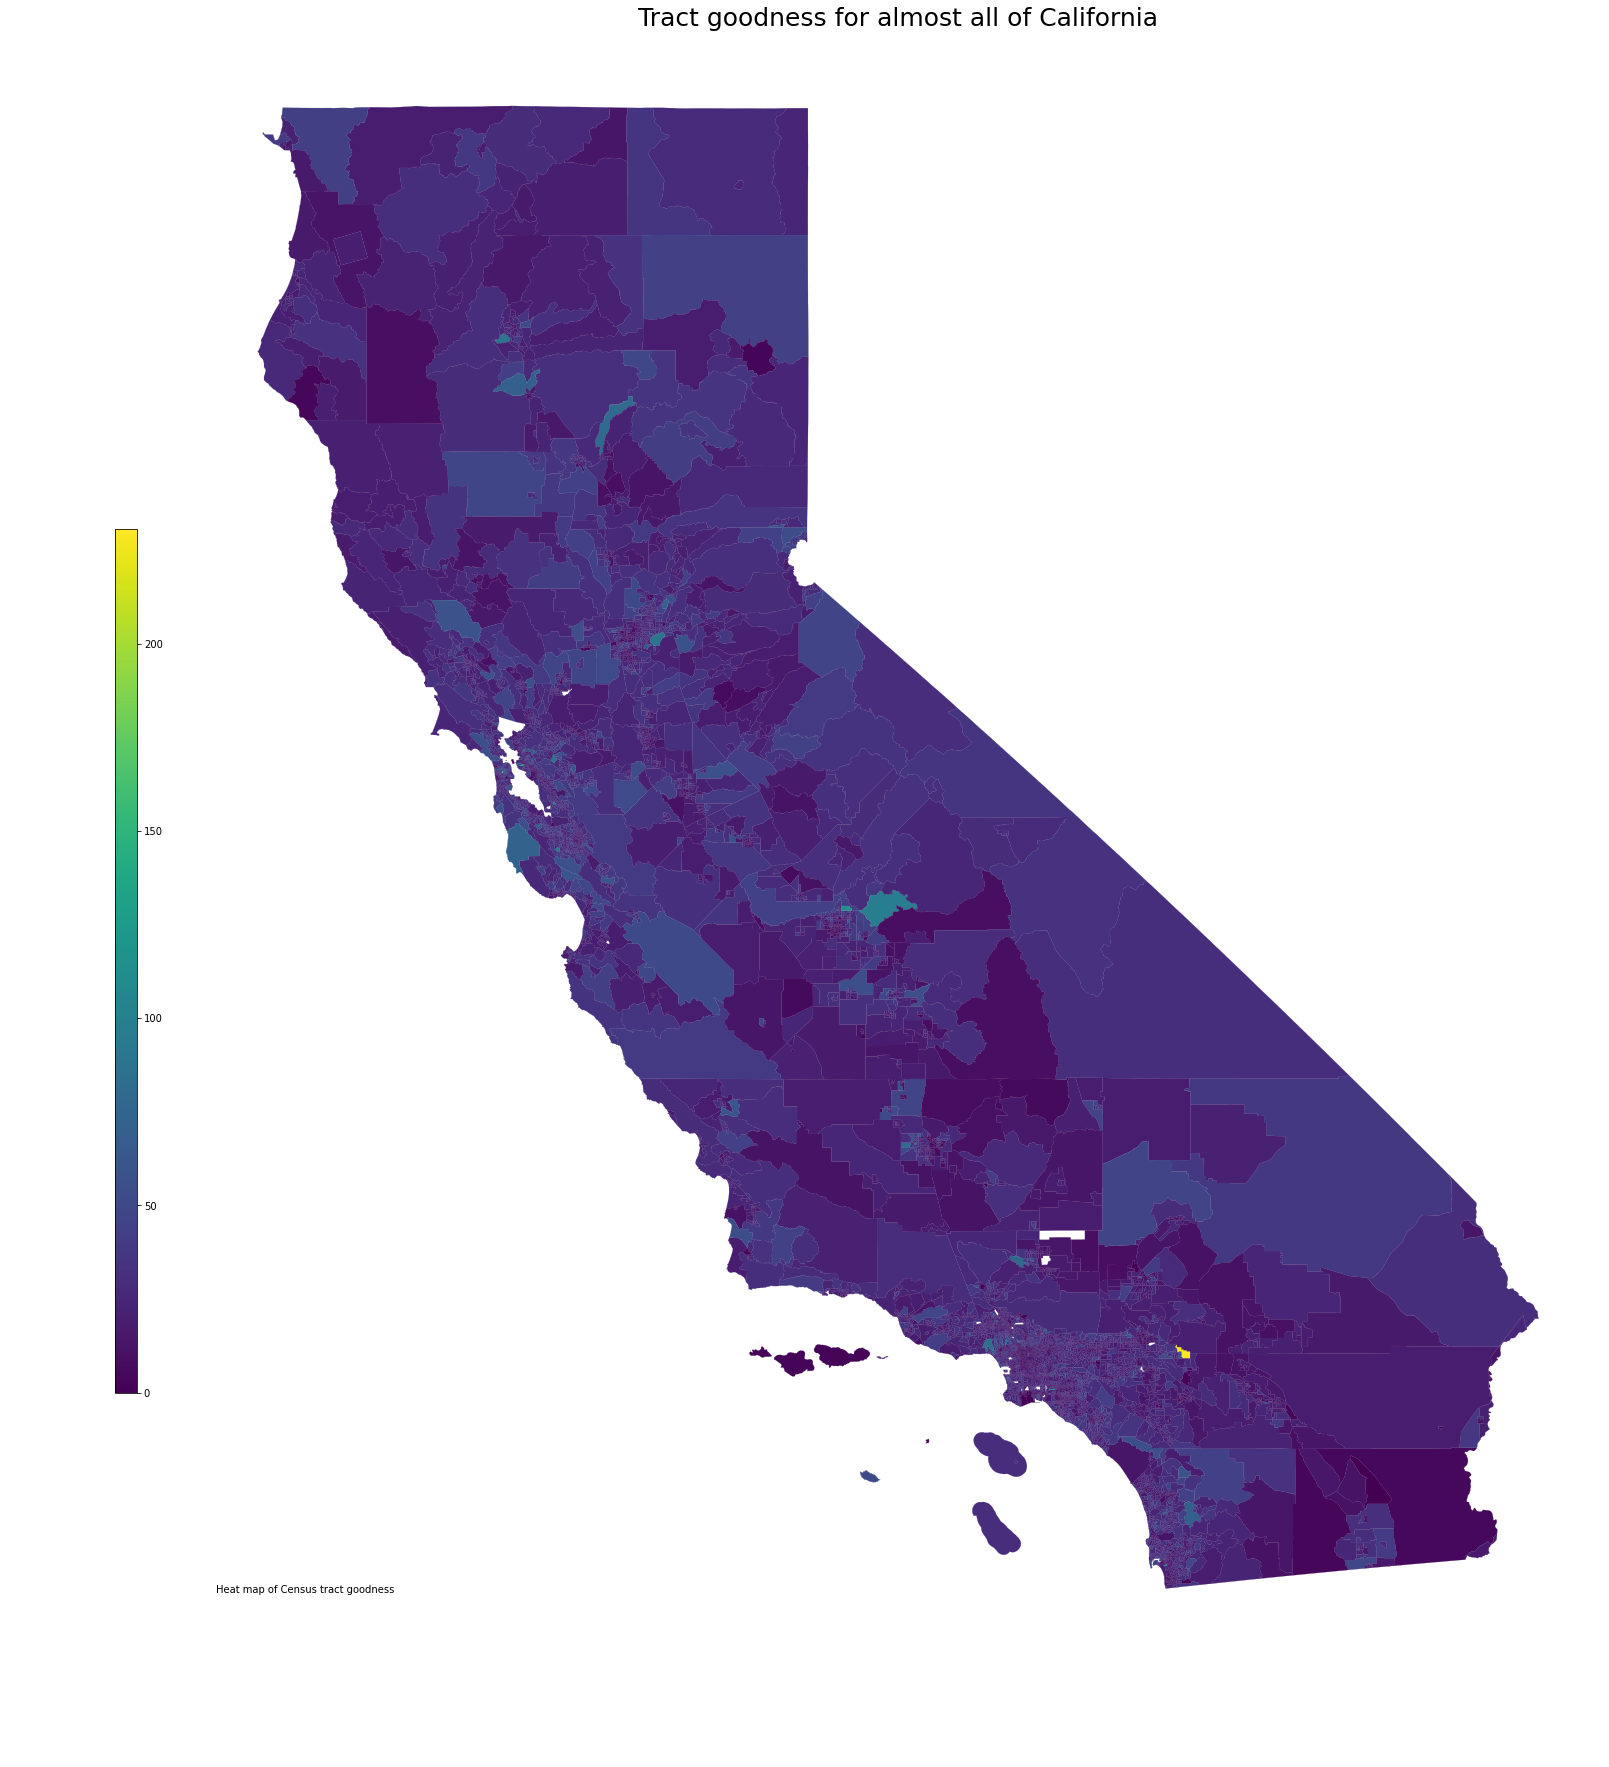

In [29]:
# Now we can make the heat map
# Example plotting with geopandas from: https://www.relataly.com/visualize-covid-19-data-on-a-geographic-heat-maps/291/

# Here df is my geopandas dataframe including my resposne variable of interest and col is the name of the response var column.
def make_heat_map(df, y_col, title, about): 
    # title = 'Goodness of selected Census tracts'
    # about = 'Heat map of Census tract goodness'
    col = df[y_col]
    vmin = col.min()
    vmax = col.max()
    cmap = 'viridis'
    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 30))
    # Remove the axis
    ax.axis('off')
    geo_df_ytg.plot(column=col, ax=ax, edgecolor="face", linewidth=0.2, cmap=cmap)
    # Add a title
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
    # Create an annotation for the data source
    ax.annotate(about, xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', 
                verticalalignment='bottom', fontsize=10)
                
    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    # Empty array for the data range
    sm._A = []
    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)

title = 'Tract goodness for almost all of California'
about = 'Heat map of Census tract goodness'
make_heat_map(geo_df_ytg, 'y_tg', title, about)

## What does the map show?
I was a little surprised by this heat map of tract goodness. I was expecting some kind of trend related to proximity to the coast or the Sierra Nevada mountain range, but that doesn't seem to be the case. One pattern I see is that tracts with higher goodness scores tend to be larger census tracts (lower population density) that border smaller tracts (higher population denisty). Maybe that means that the best communities to live in are close enough to densly populated areas to enjoy their benefits, like access to higher income jobs, while far enough away to avoid the downsides of highly populated areas (like higher rent). It would be interesting to prove this relationship If I have time later on.

There are also a series of tracts in southern california with very extremely high goodness (around 200). These may be outliers that are decreasing the predictive power of my ridge model. This should be examined as well.

## Which variables correlate with tract goodness?
Before I end this analysis I would like to take a look at the most significant tract goodness coefficients and see if we can learn anything interesting about tract goodness from our ridge model:

In [30]:
ridge_tg_coeff_df = pd.DataFrame({'X column names':X_tg_column_names, 'Ridge coefficients': ridge_model_tg.coef_})
# sort the df from largest to smallest coefficients
ridge_tg_coeff_df.sort_values(by=['Ridge coefficients'], inplace=True, ascending=False)
display(ridge_tg_coeff_df.head()) # display twenty largest coefficients
print("Let's also look at some of the negative coefficients with the largest magnitude:")
display(ridge_tg_coeff_df.tail()) # display twenty largest coefficients

,X column names,Ridge coefficients
99,B23020_001E,0.253587
84,B25018_001E,0.178082
495,B25021_001E,0.067173
285,B23013_001E,0.002707
378,B23010_001E,0.001346


Let's also look at some of the negative coefficients with the largest magnitude:


,X column names,Ridge coefficients
195,B25092_001E,-0.043515
338,B25071_001E,-0.048665
330,B25039_001E,-0.067443
65,B25010_001E,-0.344562
190,B19083_001E,-9.424479


From our ridge regression model, the three predictors with the largest positive correlation to tract goodness are:

B23020_001E : "MEAN USUAL HOURS WORKED IN THE PAST 12 MONTHS FOR WORKERS 16 TO 64 YEARS"\
B25018_001E : "MEDIAN NUMBER OF ROOMS"\
B25021_001E : "MEDIAN NUMBER OF ROOMS BY TENURE"

And the three predictors with the largest negative correlation to tract goodness are:

B19083_001E : "GINI INDEX OF INCOME INEQUALITY"\
B25010_001E : "AVERAGE HOUSEHOLD SIZE OF OCCUPIED HOUSING UNITS BY TENURE"\
B25039_001E : "MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE"

## Conclusions
* It's clear that many of these predictors are highly correlated with median household income, and that's why they were selected by the ridge model.
* One interesting observation is that "MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE" is negatively correlated with tract goodness. Does this mean that in "better" census tracts renters stay for shorter periods of time? Could this variable be a proxy for social mobility?
* This ridge regression model is not a good fit for larger (>100) tract goodness values. It would be worth treating tracts with very high goodness as outliers, removing them before making a model, then doing some regression analysis comparing the response variable (tract goodness) to some of the other significant variables This process may lead to better models or new insights.


## Next Steps: Can we improve the ridge model through regression analysis?
If I have time later on I would like to do some regression analysis and look at the statistical significance of the most significant variables chosen by my models.
I've got a few cells below that I'm playing with, but I don't have time now to continue.


# Cook's distance for outlier detection
First I'll create a new linear model using the statsmodels package. I'll use tract goodness as the response variable and the 6 selected variables from the ridge model as predictors:

(9081, 3)
(9081, 7)
(9081, 8)


c:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                   y_tg   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     739.5
Date:                Sun, 01 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:34:45   Log-Likelihood:                -32856.
No. Observations:                9081   AIC:                         6.572e+04
Df Residuals:                    9075   BIC:                         6.577e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         693.1028     57.750     12.002      

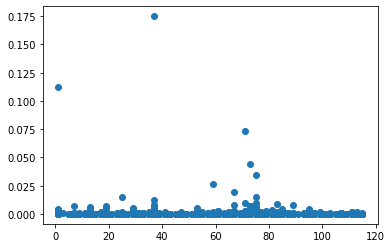

In [31]:
# print(y_tg.head())
# print(geo_df_ytg.head())

m1_X_vars = ['B23020_001E', 'B25018_001E','B19083_001E','B25010_001E','B25039_001E','county','tract'] # 5 significant predictors from ridge model above.
m1_y = geo_df_ytg[['y_tg','county','tract']] # get relavent response dataframe, include county and tract for merging.
print(m1_y.shape)
m1_X =  acs_imp_df[m1_X_vars] 
print(m1_X.shape) 

# now merge tract goodness with 5 predictors to make the m1 dataframe:
m1_df = m1_y.merge(m1_X, how='left', on = ['county','tract'])
print(m1_df.shape)

# now lets make the linear model m1 and first look at the model summary
# from statsmodels.formula.api import ols
import statsmodels.api as sm
# m1 = ols('y_tg ~ B23020_001E + B25018_001E + B19083_001E + B25010_001E + B25039_001E', m1_df)
m1 = sm.OLS(m1_df['y_tg'],sm.add_constant(m1_df[['B23020_001E', 'B25018_001E','B19083_001E','B25010_001E','B25039_001E']])).fit()
print(m1.summary())
infl = m1.get_influence()
# print(infl)
sm_fr = infl.summary_frame()

plt.scatter(m1_df['county'],sm_fr['cooks_d'])
plt.xlabel = 'Tract number'
plt.ylabel = 'Cooks distance'
plt.show()